In [ ]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 64.4 MB/s eta 0:00:00


In [ ]:
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers 
import os
from sklearn.ensemble import RandomForestClassifier
import tensorflow_decision_forests as tfdf
from sklearn.metrics import accuracy_score


In [ ]:

log_dir = "logs/"
data_dir = './PetImages/'
BATCH_SIZE = 32
BUFFER_SIZE = 1000
images_shape = [224, 224, 3]
images_size = (224, 224)
input_size = (224, 224, 3)
embedding_size = 64
class_count = 2
EPOCHS = 3

In [ ]:
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.3.0


In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2023-05-02 15:03:00--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.49.101.59, 2600:1408:ac00:18c::317f, 2600:1408:ac00:193::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.49.101.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   229MB/s    in 3.4s    

2023-05-02 15:03:03 (229 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
!unzip kagglecatsanddogs_5340.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    print("folder_name:",folder_name) #folder_name: Cat
    folder_path = os.path.join("./PetImages", folder_name)
    print("folder_path:",folder_path) #folder_path: Dataset/PetImages/Cat
    for fname in os.listdir(folder_path):
        #print("fname:",fname) #fname: 5961.jpg
        fpath = os.path.join(folder_path, fname)
        #print("fpath:", fpath) #fpath: Dataset/PetImages/Cat/10591.jpg
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

folder_name: Cat
folder_path: ./PetImages/Cat
folder_name: Dog
folder_path: ./PetImages/Dog
Deleted 1590 images


In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.5,
                                                               subset="training", seed=123,
                                                               image_size=images_size, batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.5, subset="validation", seed=123,
    image_size=images_size, batch_size=BATCH_SIZE)



Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.


In [ ]:
def define_pretrain_model(model_name,input_size,untrainable_percent=0):
  if model_name=='vgg':
    base_model=keras.applications.vgg16.VGG16(
    include_top=False,weights='imagenet',
    input_shape=input_size)

    model_preprocessor =keras.applications.vgg16.preprocess_input

  elif  model_name=='densenet':
    base_model=keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=input_size)
    model_preprocessor =keras.applications.densenet.preprocess_input


  else:
    base_model=keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_size)
    model_preprocessor =keras.applications.resnet50.preprocess_input

    
  n_layers = len(base_model.layers)
  freeze_leayer = math.ceil(n_layers*untrainable_percent)
  for layer in base_model.layers[:freeze_leayer]:
    layer.trainable=False
  

  inputs = keras.Input(shape=input_size) 
  model = model_preprocessor(inputs)
  model = base_model(model)
  model=layers.Flatten()(model)
  model = layers.Dense(256,activation='relu')(model)
  model = layers.Dropout(0.5)(model)
  feature = layers.Dense(64, activation='relu', name='feature')(model)
  out = layers.Dense(1,activation='sigmoid')(feature)
  calssification_model = keras.Model(inputs,out)
  feature_model = keras.Model(inputs,feature)

  lr=0.0001
  calssification_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return calssification_model,feature_model

 
  



In [ ]:
def fine_tune(name,input_size,untrainable_percent):
  calssification_model,feature_model=define_pretrain_model(name,input_size,untrainable_percent)
  history = calssification_model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)
  return history,feature_model

In [ ]:
history,feature_model = fine_tune('vgg',input_size,0.1)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


366/366 [==============================] - 198s 507ms/step - loss: 0.4346 - accuracy: 0.7905 - val_loss: 0.1037 - val_accuracy: 0.9595
Epoch 2/3
366/366 [==============================] - 180s 492ms/step - loss: 0.0936 - accuracy: 0.9643 - val_loss: 0.1430 - val_accuracy: 0.9533
Epoch 3/3
366/366 [==============================] - 180s 491ms/step - loss: 0.0620 - accuracy: 0.9773 - val_loss: 0.0909 - val_accuracy: 0.9710


In [ ]:
history.history  ## vgg ,untrainable_percent=0.1

{'loss': [0.43463221192359924, 0.09364467114210129, 0.06202632933855057],
 'accuracy': [0.7905168533325195, 0.9642887711524963, 0.9772746562957764],
 'val_loss': [0.10370822250843048, 0.14303576946258545, 0.09087219834327698],
 'val_accuracy': [0.9595044851303101, 0.9532678127288818, 0.970952570438385]}

In [ ]:
def plot(history,name,freeze_percent):  
  
  acc=history.history['accuracy']
  val_acc = history.history['val_accuracy']
      
  loss = history.history['loss']
  val_loss = history.history['val_loss']
      
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()), 1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
 
  plt.legend(loc='lower left')
  plt.ylabel('Loss')
  plt.ylim([0, 1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
      
  plt.savefig(name+'_'+str(freeze_percent)+'.png')

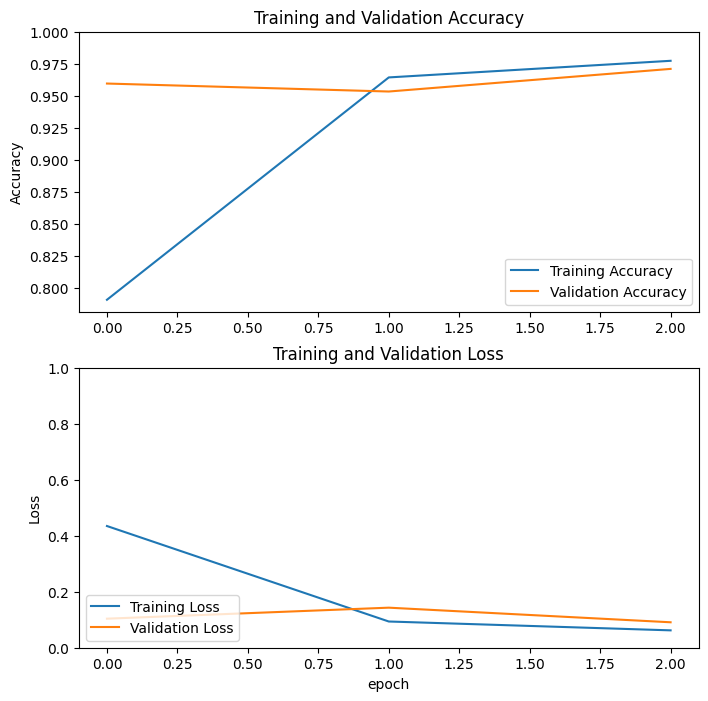

In [ ]:
plot(history,'vgg',10)

In [ ]:
history_vgg_30,feature_model_vgg_30 = fine_tune('vgg',input_size,0.3)

Epoch 1/3
366/366 [==============================] - 141s 370ms/step - loss: 0.7370 - accuracy: 0.5336 - val_loss: 0.6932 - val_accuracy: 0.5018
Epoch 2/3
366/366 [==============================] - 135s 367ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 3/3
366/366 [==============================] - 135s 368ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5027


In [ ]:
history_vgg_30.history

{'loss': [0.7369964122772217, 0.6932032108306885, 0.6932100057601929],
 'accuracy': [0.5336180925369263, 0.49799230694770813, 0.5013242363929749],
 'val_loss': [0.6931582689285278, 0.6931531429290771, 0.6931329965591431],
 'val_accuracy': [0.5017513632774353, 0.49747970700263977, 0.5026911497116089]}

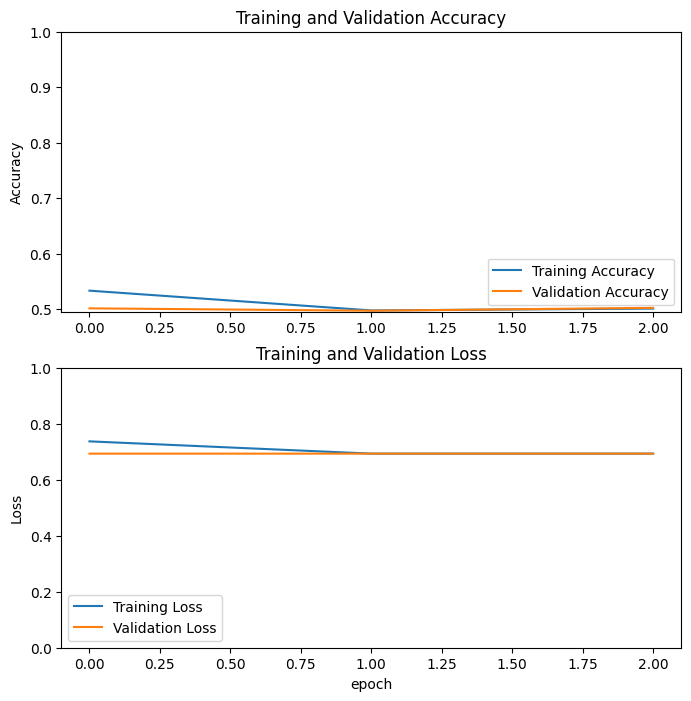

In [ ]:
plot(history_vgg_30,'vgg',30)

In [ ]:
history_vgg_50,feature_model_vgg_50 = fine_tune('vgg',input_size,0.5)

Epoch 1/3
366/366 [==============================] - 120s 318ms/step - loss: 0.2550 - accuracy: 0.9102 - val_loss: 0.0832 - val_accuracy: 0.9703
Epoch 2/3
366/366 [==============================] - 154s 420ms/step - loss: 0.0823 - accuracy: 0.9704 - val_loss: 0.1073 - val_accuracy: 0.9653
Epoch 3/3
366/366 [==============================] - 116s 317ms/step - loss: 0.0472 - accuracy: 0.9811 - val_loss: 0.0727 - val_accuracy: 0.9768


In [ ]:
history_vgg_50.history

{'loss': [0.25504887104034424, 0.08228344470262527, 0.04720352962613106],
 'accuracy': [0.9102092981338501, 0.9703545570373535, 0.9811191558837891],
 'val_loss': [0.08319629728794098, 0.10732196271419525, 0.07265348732471466],
 'val_accuracy': [0.9702691435813904, 0.9653139710426331, 0.976762056350708]}

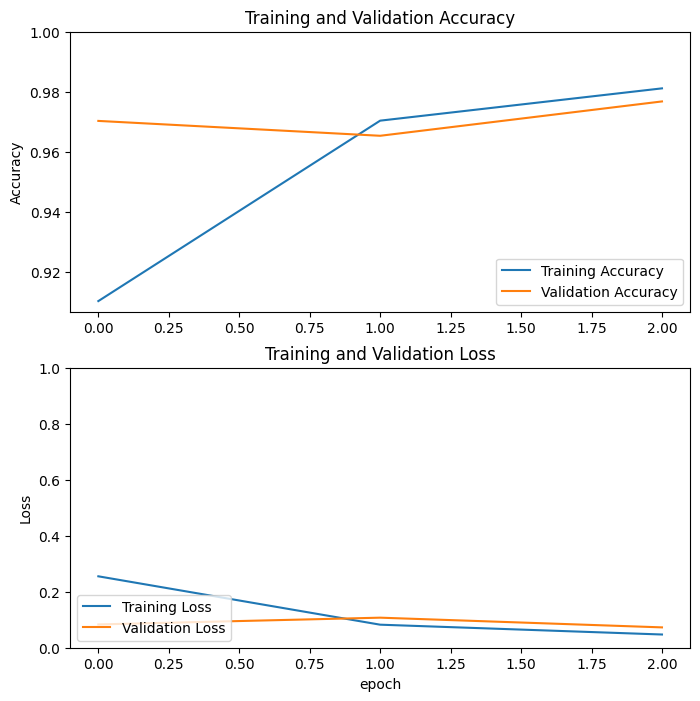

In [ ]:
plot(history_vgg_50,'vgg',50)

In [ ]:
history_vgg_70,feature_model_vgg_70 = fine_tune('vgg',input_size,0.7)

Epoch 1/3
366/366 [==============================] - 102s 272ms/step - loss: 0.1905 - accuracy: 0.9524 - val_loss: 0.0825 - val_accuracy: 0.9722
Epoch 2/3
366/366 [==============================] - 99s 271ms/step - loss: 0.0672 - accuracy: 0.9776 - val_loss: 0.0618 - val_accuracy: 0.9774
Epoch 3/3
366/366 [==============================] - 99s 271ms/step - loss: 0.0502 - accuracy: 0.9841 - val_loss: 0.0756 - val_accuracy: 0.9832


In [ ]:
history_vgg_70.history

{'loss': [0.19047054648399353, 0.06720694154500961, 0.05020787939429283],
 'accuracy': [0.9524134993553162, 0.9776164293289185, 0.9841093420982361],
 'val_loss': [0.08248583227396011, 0.06180552393198013, 0.07563713192939758],
 'val_accuracy': [0.9722340703010559, 0.9773601293563843, 0.9831696152687073]}

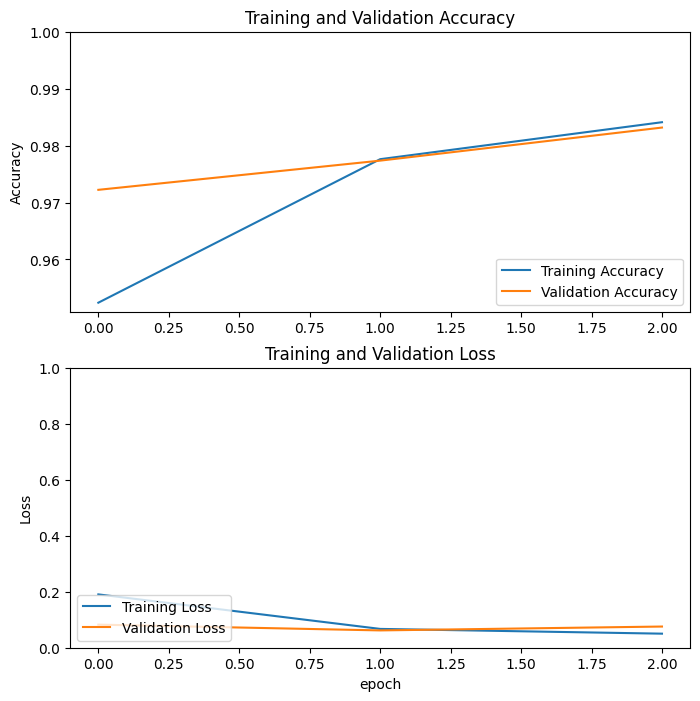

In [ ]:
plot(history_vgg_70,'vgg',70)

In [ ]:
history_vgg_100,feature_model_vgg_100 = fine_tune('vgg',input_size,1)

Epoch 1/3
366/366 [==============================] - 93s 248ms/step - loss: 0.3993 - accuracy: 0.9475 - val_loss: 0.1473 - val_accuracy: 0.9765
Epoch 2/3
366/366 [==============================] - 91s 249ms/step - loss: 0.1178 - accuracy: 0.9801 - val_loss: 0.1647 - val_accuracy: 0.9778
Epoch 3/3
366/366 [==============================] - 91s 248ms/step - loss: 0.0930 - accuracy: 0.9852 - val_loss: 0.0970 - val_accuracy: 0.9826


In [ ]:
history_vgg_100.history

{'loss': [0.39928874373435974, 0.11776216328144073, 0.09302107989788055],
 'accuracy': [0.9474583268165588, 0.9800939559936523, 0.9852200150489807],
 'val_loss': [0.1473134160041809, 0.16466645896434784, 0.09699700027704239],
 'val_accuracy': [0.9765057563781738, 0.9777872562408447, 0.982571542263031]}

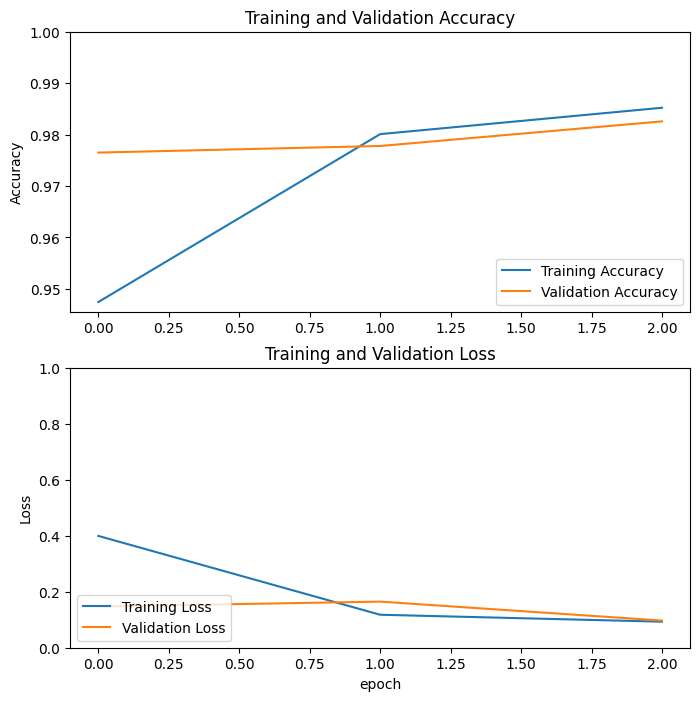

In [ ]:
plot(history_vgg_100,'vgg',100)

In [ ]:
history_densenet_10,feature_model_densenet_10 = fine_tune('densenet',input_size,0.1)

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


366/366 [==============================] - 202s 362ms/step - loss: 0.0951 - accuracy: 0.9695 - val_loss: 0.0468 - val_accuracy: 0.9856
Epoch 2/3
366/366 [==============================] - 127s 346ms/step - loss: 0.0257 - accuracy: 0.9913 - val_loss: 0.0305 - val_accuracy: 0.9907
Epoch 3/3
366/366 [==============================] - 127s 346ms/step - loss: 0.0225 - accuracy: 0.9936 - val_loss: 0.0345 - val_accuracy: 0.9912


In [ ]:
history_densenet_10.history

{'loss': [0.09512081742286682, 0.025710545480251312, 0.022522611543536186],
 'accuracy': [0.9695001840591431, 0.9912858009338379, 0.9935925006866455],
 'val_loss': [0.04684222862124443, 0.030490582808852196, 0.03453841432929039],
 'val_accuracy': [0.9856471419334412, 0.9906877279281616, 0.99120032787323]}

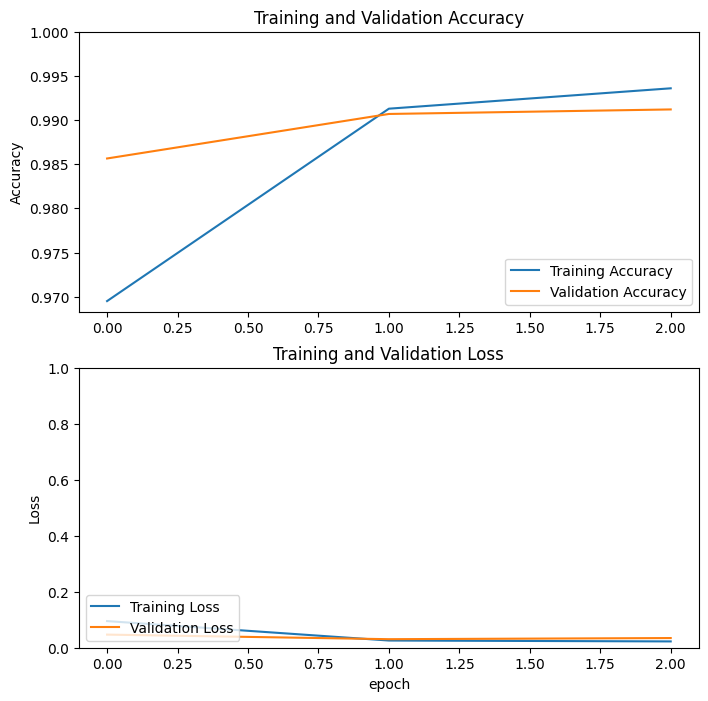

In [ ]:
plot(history_densenet_10,'densenet',10)

In [ ]:
history_densenet_30,feature_model_densenet_30 = fine_tune('densenet',input_size,0.3)

Epoch 1/3
366/366 [==============================] - 149s 278ms/step - loss: 0.0954 - accuracy: 0.9654 - val_loss: 0.0575 - val_accuracy: 0.9808
Epoch 2/3
366/366 [==============================] - 100s 274ms/step - loss: 0.0324 - accuracy: 0.9882 - val_loss: 0.0493 - val_accuracy: 0.9857
Epoch 3/3
366/366 [==============================] - 101s 275ms/step - loss: 0.0142 - accuracy: 0.9947 - val_loss: 0.0314 - val_accuracy: 0.9905


In [ ]:
history_densenet_30.history

{'loss': [0.09540891647338867, 0.032449718564748764, 0.014249254018068314],
 'accuracy': [0.9653993844985962, 0.988210141658783, 0.9947031140327454],
 'val_loss': [0.057468246668577194, 0.04934701323509216, 0.0313887856900692],
 'val_accuracy': [0.9807774424552917, 0.9857326149940491, 0.9905169010162354]}

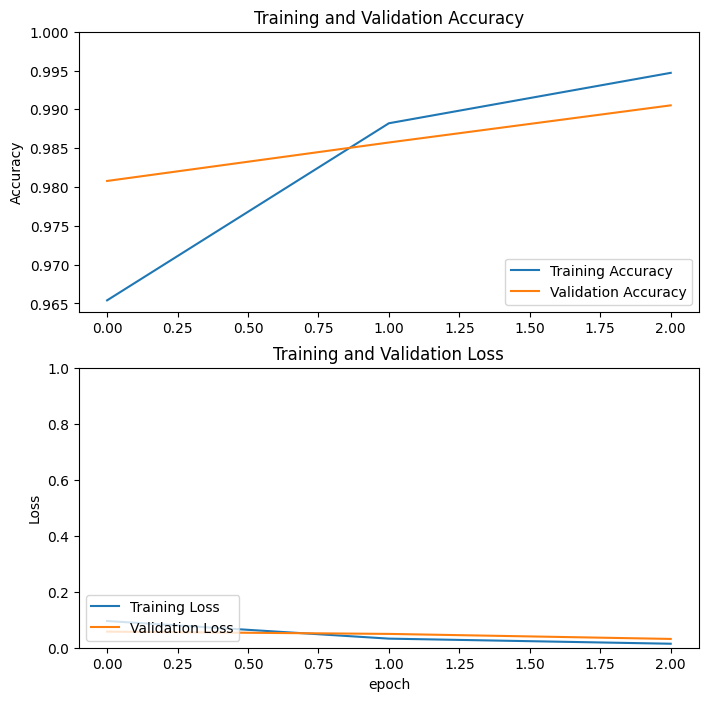

In [ ]:
plot(history_densenet_30,'densenet',30)

In [ ]:
history_densenet_50,feature_model_densenet_50 = fine_tune('densenet',input_size,0.5)

Epoch 1/3
366/366 [==============================] - 132s 263ms/step - loss: 0.0917 - accuracy: 0.9702 - val_loss: 0.0347 - val_accuracy: 0.9888
Epoch 2/3
366/366 [==============================] - 98s 267ms/step - loss: 0.0264 - accuracy: 0.9915 - val_loss: 0.0338 - val_accuracy: 0.9903
Epoch 3/3
366/366 [==============================] - 98s 267ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0323 - val_accuracy: 0.9920


In [ ]:
history_densenet_50.history

{'loss': [0.09174198657274246, 0.026392271742224693, 0.013270705938339233],
 'accuracy': [0.9701836705207825, 0.9915421009063721, 0.9958992004394531],
 'val_loss': [0.03468990698456764, 0.03384752571582794, 0.032324157655239105],
 'val_accuracy': [0.9888082146644592, 0.9903460144996643, 0.9919692277908325]}

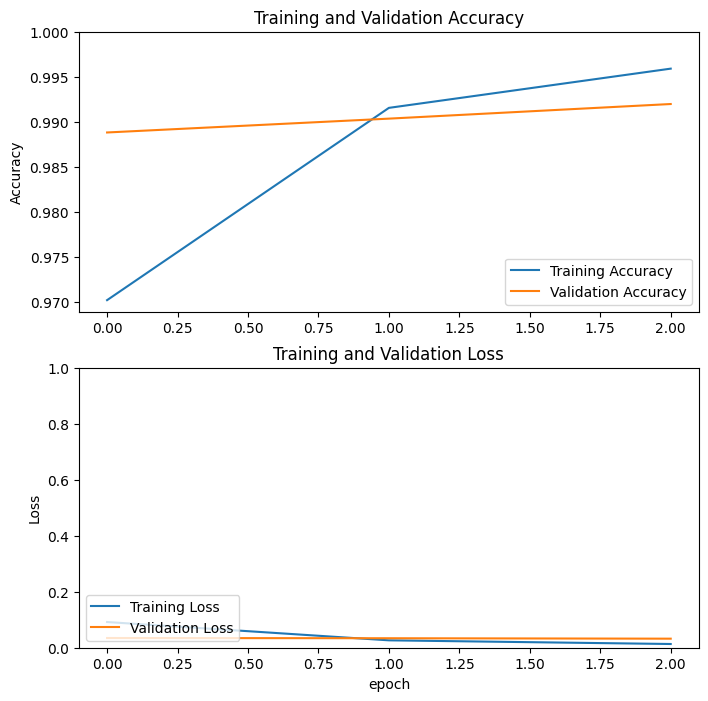

In [ ]:
plot(history_densenet_50,'densenet',50)

In [ ]:
history_densenet_70,feature_model_densenet_70 = fine_tune('densenet',input_size,0.7)

Epoch 1/3
366/366 [==============================] - 103s 218ms/step - loss: 0.0729 - accuracy: 0.9754 - val_loss: 0.0211 - val_accuracy: 0.9931
Epoch 2/3
366/366 [==============================] - 87s 236ms/step - loss: 0.0247 - accuracy: 0.9918 - val_loss: 0.0550 - val_accuracy: 0.9837
Epoch 3/3
366/366 [==============================] - 86s 235ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.0266 - val_accuracy: 0.9923


In [ ]:
history_densenet_70.history

{'loss': [0.07288791984319687, 0.02468361333012581, 0.014931016601622105],
 'accuracy': [0.975395143032074, 0.9917984008789062, 0.9953011274337769],
 'val_loss': [0.02113719843327999, 0.055041491985321045, 0.026633668690919876],
 'val_accuracy': [0.9930799007415771, 0.9836822152137756, 0.9923110008239746]}

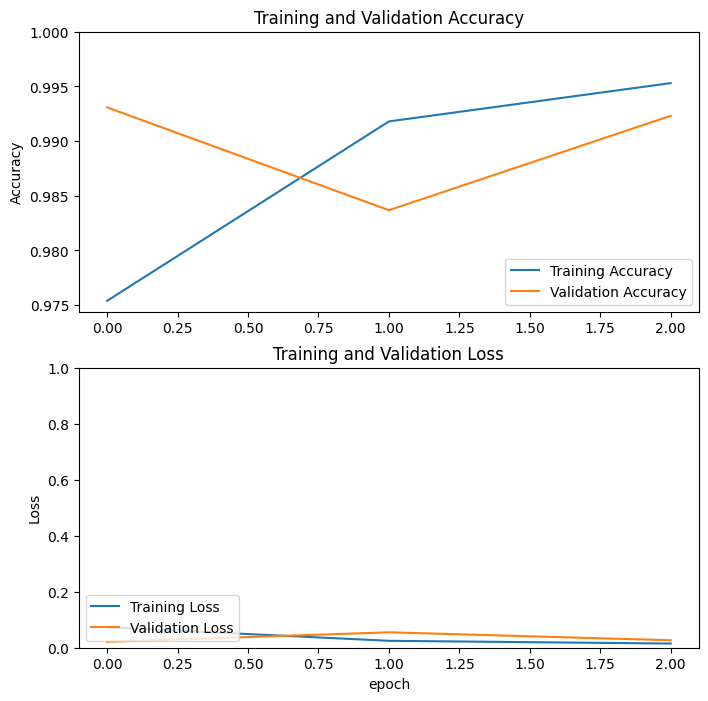

In [ ]:
plot(history_densenet_70,'densenet',70)

In [ ]:
history_densenet_100,feature_model_densenet_100 = fine_tune('densenet',input_size,1)

Epoch 1/3
366/366 [==============================] - 78s 192ms/step - loss: 0.0765 - accuracy: 0.9773 - val_loss: 0.0479 - val_accuracy: 0.9839
Epoch 2/3
366/366 [==============================] - 69s 187ms/step - loss: 0.0290 - accuracy: 0.9907 - val_loss: 0.0295 - val_accuracy: 0.9914
Epoch 3/3
366/366 [==============================] - 68s 186ms/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 0.0462 - val_accuracy: 0.9884


In [ ]:
history_densenet_100.history

{'loss': [0.07651257514953613, 0.028959903866052628, 0.026795925572514534],
 'accuracy': [0.9772746562957764, 0.9906877279281616, 0.9915421009063721],
 'val_loss': [0.04793895035982132, 0.029537998139858246, 0.04618502035737038],
 'val_accuracy': [0.9839385151863098, 0.991371214389801, 0.988381028175354]}

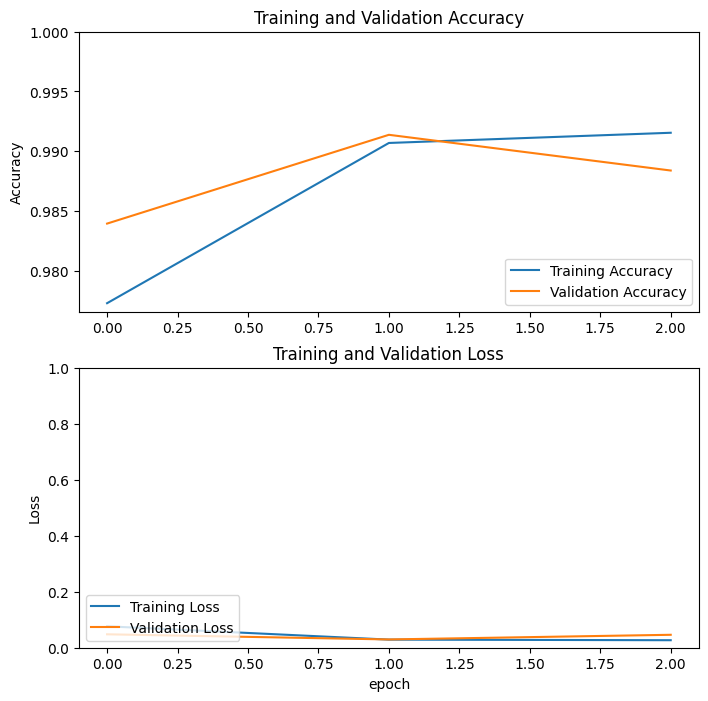

In [ ]:
plot(history_densenet_100,'densenet',100)

In [ ]:
history_resnet_10,feature_model_resnet_10 = fine_tune('resnet',input_size,0.1)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/3
366/366 [==============================] - 179s 385ms/step - loss: 0.1175 - accuracy: 0.9646 - val_loss: 0.8920 - val_accuracy: 0.9440
Epoch 2/3
366/366 [==============================] - 138s 376ms/step - loss: 0.0426 - accuracy: 0.9880 - val_loss: 0.0492 - val_accuracy: 0.9867
Epoch 3/3
366/366 [==============================] - 138s 377ms/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.0752 - val_accuracy: 0.9789


In [ ]:
history_resnet_10.history

{'loss': [0.1175067275762558, 0.042571138590574265, 0.02056259661912918],
 'accuracy': [0.9646304845809937, 0.9879538416862488, 0.9941051006317139],
 'val_loss': [0.8919730186462402, 0.04922253638505936, 0.07523772865533829],
 'val_accuracy': [0.9439556002616882, 0.9866723418235779, 0.9788979291915894]}

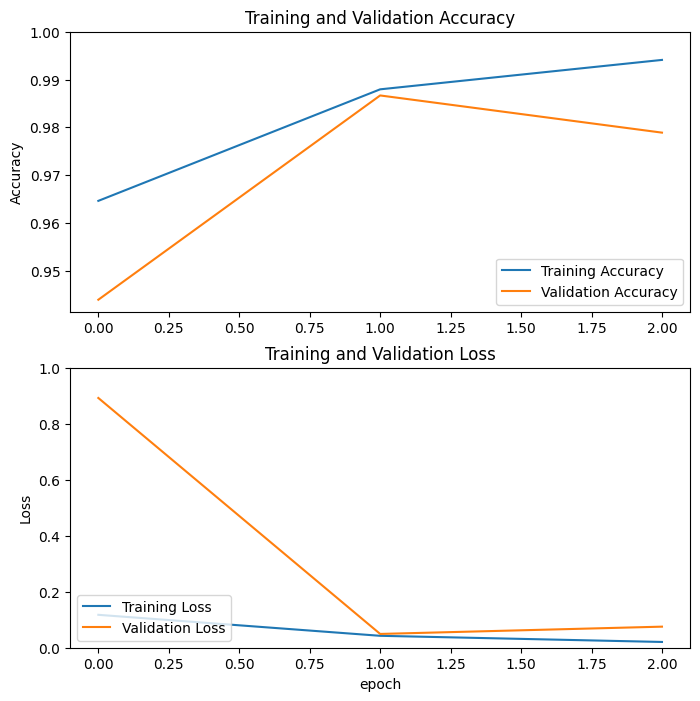

In [ ]:
plot(history_resnet_10,'resnet',10)

In [ ]:
history_resnet_30,feature_model_resnet_30 = fine_tune('resnet',input_size,0.3)

Epoch 1/3
366/366 [==============================] - 151s 323ms/step - loss: 0.1148 - accuracy: 0.9653 - val_loss: 0.0541 - val_accuracy: 0.9843
Epoch 2/3
366/366 [==============================] - 117s 319ms/step - loss: 0.0348 - accuracy: 0.9887 - val_loss: 0.0772 - val_accuracy: 0.9816
Epoch 3/3
366/366 [==============================] - 116s 317ms/step - loss: 0.0126 - accuracy: 0.9955 - val_loss: 0.1022 - val_accuracy: 0.9751


In [ ]:
history_resnet_30.history

{'loss': [0.11484291404485703, 0.034763842821121216, 0.01261979155242443],
 'accuracy': [0.9653139710426331, 0.9887227416038513, 0.9954720139503479],
 'val_loss': [0.054109588265419006, 0.07719030231237411, 0.10221032053232193],
 'val_accuracy': [0.9842802286148071, 0.9816317558288574, 0.9750533699989319]}

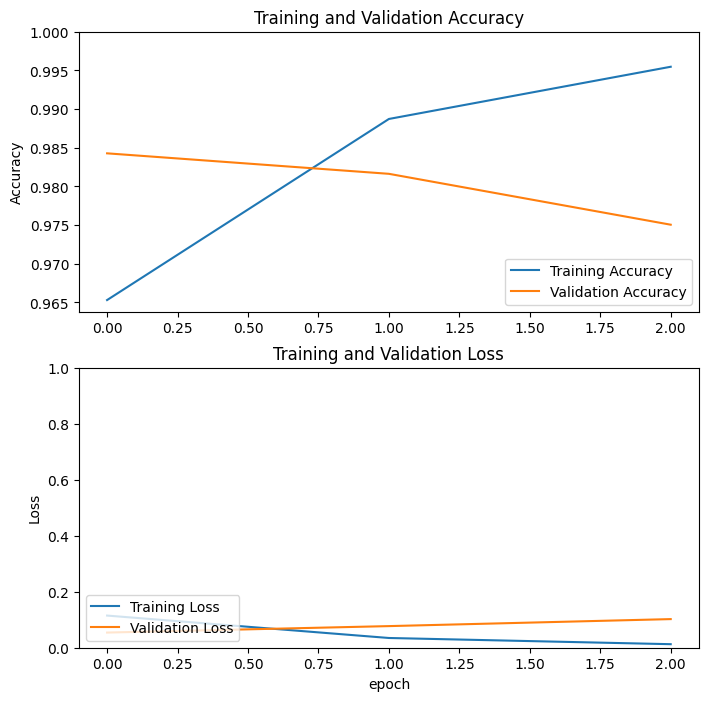

In [ ]:
plot(history_resnet_30,'resnet',30)

In [ ]:
history_resnet_50,el_resnet_50 = fine_tune('resnet',input_size,0.5)

Epoch 1/3
366/366 [==============================] - 123s 281ms/step - loss: 0.1303 - accuracy: 0.9611 - val_loss: 0.0605 - val_accuracy: 0.9828
Epoch 2/3
366/366 [==============================] - 102s 279ms/step - loss: 0.0326 - accuracy: 0.9881 - val_loss: 0.0586 - val_accuracy: 0.9859
Epoch 3/3
366/366 [==============================] - 109s 298ms/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 0.0535 - val_accuracy: 0.9870


In [ ]:
history_resnet_50.history

{'loss': [0.13029350340366364, 0.03258894756436348, 0.020244959741830826],
 'accuracy': [0.9611276984214783, 0.9881247282028198, 0.9930799007415771],
 'val_loss': [0.06049229949712753, 0.058570947498083115, 0.0535065159201622],
 'val_accuracy': [0.9828278422355652, 0.9859034419059753, 0.98701411485672]}

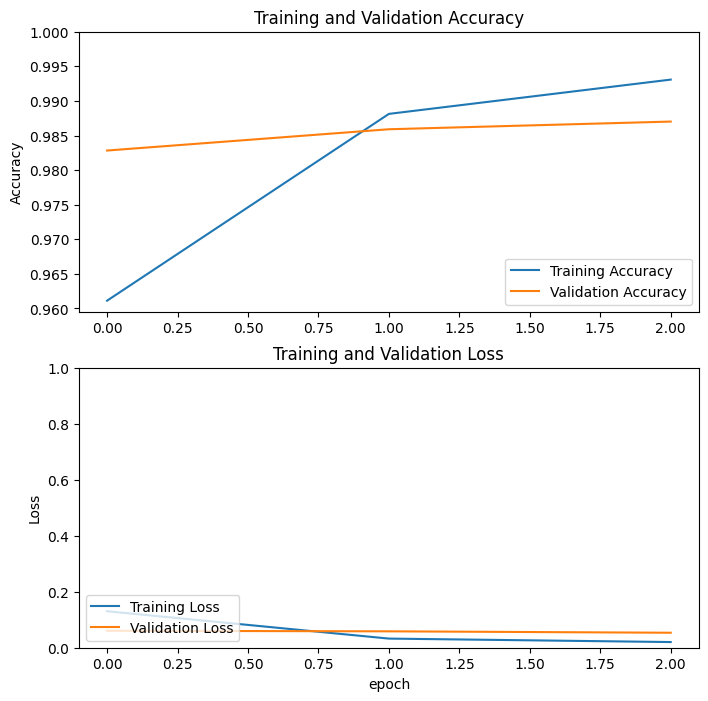

In [ ]:
plot(history_resnet_50,'resnet',50)

In [ ]:
history_resnet_70,feature_model_resnet_70 = fine_tune('resnet',input_size,0.7)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


366/366 [==============================] - 114s 270ms/step - loss: 0.1173 - accuracy: 0.9647 - val_loss: 0.0481 - val_accuracy: 0.9847
Epoch 2/3
366/366 [==============================] - 98s 268ms/step - loss: 0.0322 - accuracy: 0.9898 - val_loss: 0.0545 - val_accuracy: 0.9862
Epoch 3/3
366/366 [==============================] - 99s 269ms/step - loss: 0.0119 - accuracy: 0.9958 - val_loss: 0.0643 - val_accuracy: 0.9876


In [ ]:
history_resnet_70.history

{'loss': [0.11725666373968124, 0.03217688947916031, 0.011869540438055992],
 'accuracy': [0.9647159576416016, 0.989833414554596, 0.9958137273788452],
 'val_loss': [0.04812915250658989, 0.054519057273864746, 0.06425967067480087],
 'val_accuracy': [0.9847074151039124, 0.9862452149391174, 0.9876121282577515]}

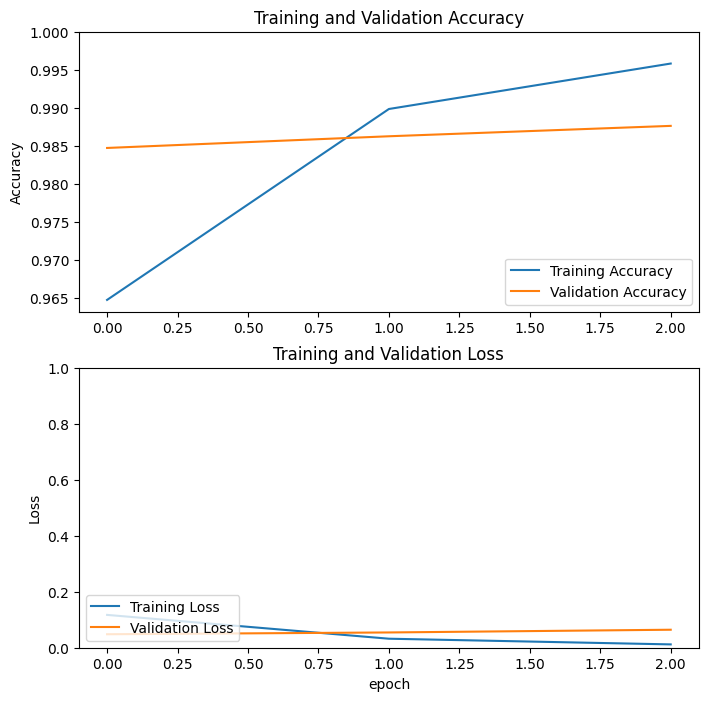

In [ ]:
plot(history_resnet_70,'resnet',70)

In [ ]:
history_resnet_100,feature_model_resnet_100 = fine_tune('resnet',input_size,1)

Epoch 1/3
366/366 [==============================] - 77s 196ms/step - loss: 0.1493 - accuracy: 0.9644 - val_loss: 0.0520 - val_accuracy: 0.9866
Epoch 2/3
366/366 [==============================] - 71s 193ms/step - loss: 0.0491 - accuracy: 0.9893 - val_loss: 0.0641 - val_accuracy: 0.9864
Epoch 3/3
366/366 [==============================] - 71s 194ms/step - loss: 0.0401 - accuracy: 0.9901 - val_loss: 0.0679 - val_accuracy: 0.9858


In [ ]:
history_resnet_100.history

{'loss': [0.14929503202438354, 0.04910556972026825, 0.04013046622276306],
 'accuracy': [0.9643741846084595, 0.9893208146095276, 0.9900897145271301],
 'val_loss': [0.05203304812312126, 0.06410323828458786, 0.06785210222005844],
 'val_accuracy': [0.9865869283676147, 0.9864160418510437, 0.9858180284500122]}

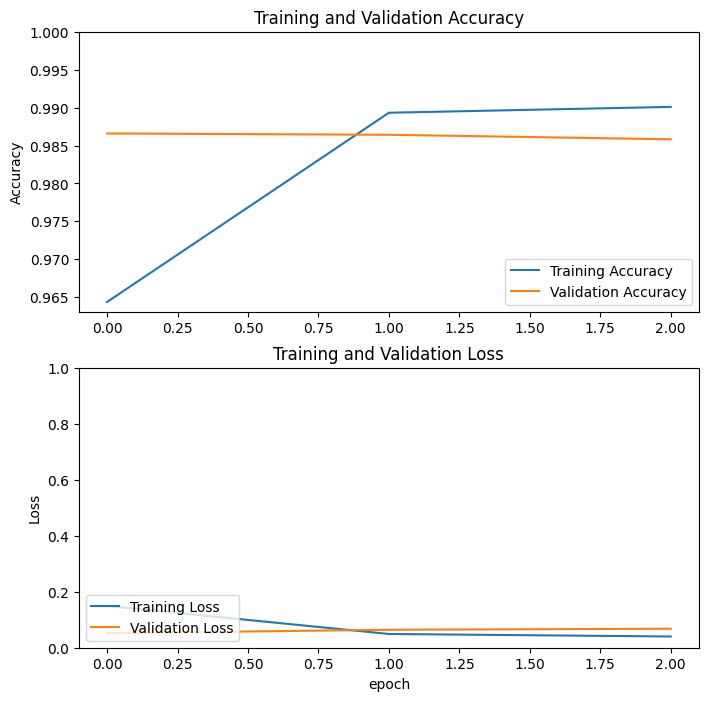

In [ ]:
plot(history_resnet_100,'resnet',100)

In [ ]:
def random_forest_classifier(feature_model,train_ds,val_ds):
  random_forest_clf = RandomForestClassifier(warm_start=True,max_depth=8, random_state=0, n_estimators = 1)
 
  predictions=np.array([])
  ground_truth = np.array([])

  for image, label in train_ds.take(-1):
    features = feature_model.predict(image,verbose=0)
    random_forest_clf.fit(features, label)
    random_forest_clf.n_estimators+=1

  for image,label in val_ds.take(-1):
    val_featurs =  feature_model.predict(image,verbose=0)
    pred = random_forest_clf.predict(val_featurs)
    predictions=np.concatenate([predictions,pred])
    ground_truth = np.concatenate([ground_truth,label.numpy()])

  print(accuracy_score(ground_truth, predictions))    


In [ ]:
#Add random_forest_classifier on top of features axtracted from the best variantions of vgg , resnet , densenet which is
# vgg 10 untrainable_percent 
# densenet 30 untrainable_percent
# resnet 10 untrainable_percent

In [ ]:
### random_forest_classifier validation accuracy on top of vgg16 ,untrainable_percent=0.1  
random_forest_classifier(feature_model,train_ds,val_ds)

In [ ]:
### random_forest_classifier validation accuracy on top of densenet121 ,untrainable_percent=0.3 
random_forest_classifier(feature_model_densenet_30,train_ds,val_ds)

In [ ]:
### random_forest_classifier validation accuracy on top of resenet50 ,untrainable_percent=0.1
random_forest_classifier(feature_model_resnet_10,train_ds,val_ds)